In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm
from numpy.linalg import inv

### 이 예제에서는 vector $\mathbf{x}$의 dimension이 1이고, basis function $\phi(\mathbf{x})=(1, \mathbf{x})$인 경우를 예로 듭니다.

### Gaussian Class


In [2]:
class Gaussian():
    def __init__(self, mean, covariace):
        self.mean = mean
        self.covariance = covariance
        
    def sample(self, size=1):
        return multivariate_normal.rvs(mean=self.mean, cov=self.covariance, size=size)
    
    def pdf(self, x):
        return multivariate_normal.pdf(x, mean=self.mean, cov=self.covariance)

### Likelihood Function

Linear regression에서 함수값 $y(\mathbf{x}, \mathbf{w})$는 다음과 같이 weight $\mathbf{w}$와 vector $\boldsymbol{\phi}(\mathbf{x})$의 내적으로 주어집니다.

$y(\mathbf{x}, \mathbf{w})=\sum_{j=0}^{M-1} w_{j} \phi_{j}(\mathbf{x})=\mathbf{w}^{\mathrm{T}} \boldsymbol{\phi}(\mathbf{x}), \text { where } \mathbf{w}=\left(w_{0}, \ldots, w_{M-1}\right)^{\mathrm{T}} \text { and } \phi=\left(\phi_{0}, \ldots, \phi_{M-1}\right)^{\mathrm{T}}$

이 때, likelihood function은 다음과 같이 주어집니다. $t$에 대한 probability distribution 식이지만 likelihood function으로 생각할 때는 $\mathbf{w}$가 domain임을 기억해야 합니다.


$p(t \mid \mathbf{x}, \mathbf{w}, \beta)=\mathcal{N}\left(t \mid y(\mathbf{x}, \mathbf{w}), \beta^{-1}\right)$

In [3]:
def likelihood(x, t, w, beta):
    # x : scalar, domain value
    # t : scalar, target value
    # w : (N, 2,), weight
    # beta : scalar, data precision

    mean = w[:, 0] + w[:, 1] * x
    std = np.sqrt(1/beta)
    pdf = norm.pdf(t, mean, std)
    return pdf

In [12]:
def plot(data, posterior, beta=10, sample_num=10):
    
    # Get weight coordinates from (-3, -3) to (3, 3)
    xx = np.linspace(-3, 3, 100)
    yy = np.linspace(-3, 3, 100)
    # (10000, 2)
    coords = np.array([[x_, y_] for y_ in xx for x_ in xx])
    
    plt.figure(figsize=[10, 3])
    # Draw Likelihood
    if data is not None:
        plt.subplot(1, 3, 1)
        plt.title('Likelihood')
        x, t = data
    
        likelihood_values = likelihood(x, t, coords, beta)    
        plt.scatter(coords[:, 0], coords[:, 1], cmap='jet', c=likelihood_values, alpha=0.1)
        plt.xlim([-3, 3])
        plt.ylim([-3, 3])
    else:
        plt.subplot(1, 3, 1)
        plt.xlim([-3, 3])
        plt.ylim([-3, 3])
        
    # Draw Posterior    
    if posterior is not None:
        plt.subplot(1, 3, 2)
        plt.title('Prior/Posterior')
        
        # Draw pdf
        poseterior_pdf = posterior.pdf(coords)
        plt.scatter(coords[:, 0], coords[:, 1], cmap='jet', c=poseterior_pdf, alpha=0.1)
        
        # Draw samples
        w_samples = posterior.sample(sample_num)
        for w_sample in w_samples:
            plt.scatter(w_sample[0], w_sample[1], color='white', s=3, alpha=0.8)
        plt.xlim([-3, 3])
        plt.ylim([-3, 3])
       
        plt.subplot(1, 3, 3)
        plt.title('Data space')
        x = np.linspace(-1, 1)
        for w_sample in w_samples:
            y = w_sample[0] + w_sample[1] * x
            plt.plot(x, y, linewidth=2, color='red', alpha=0.2)
            
        if data is not None:
            plt.scatter(data[0], data[1], facecolors='none', color='blue', marker='o')
        plt.xlim([-1, 1])
        plt.ylim([-1, 1])
        
    plt.show()    
                

### Posterior Update
prior가 다음과 같이 주어질 때,
$p(w)=N(w|m_0,S_0)$

데이터 $(x, t)$를 관찰(observed)하고 나면 다음과 같이 posterior를 update할 수 있습니다.

$p(w|t)=N(w|m_N, S_N)$

where, $\begin{array}{l}
\mathbf{m}_{N}=\mathbf{S}_{N}\left(\mathbf{S}_{0}^{-1} \mathbf{m}_{0}+\beta \mathbf{\Phi}^{\mathrm{T}} \mathbf{t}\right) \\
\mathbf{S}_{N}^{-1}=\mathbf{S}_{0}^{-1}+\beta \mathbf{\Phi}^{\mathrm{T}} \mathbf{\Phi}
\end{array}$


In [13]:
def update(data, m_0, S_0, beta):
    # data : (x, t)
    # m_0 : (2,), mean of prior
    # S_0 : (2, 2), covariance of prior
    
    # (1, 2), design matrix
    design = np.array([[1, data[0]]])
    # (1, 1), target value
    t = np.array([data[1],])
    
    # (2, 2), updated covariance matrix
    S_N = inv(inv(S_0) + beta * design.T @ design)
    # scalar, updated mean
    m_N = S_N @ (inv(S_0) @ m_0 + beta * design.T @ t)
    
    return m_N, S_N

### Posterior Update and Plot

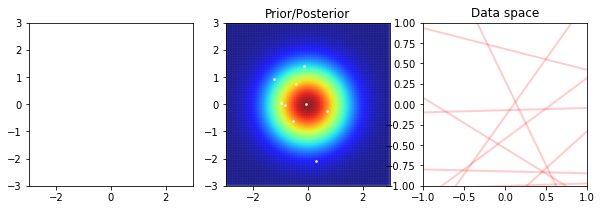

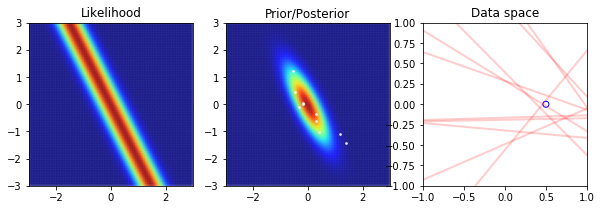

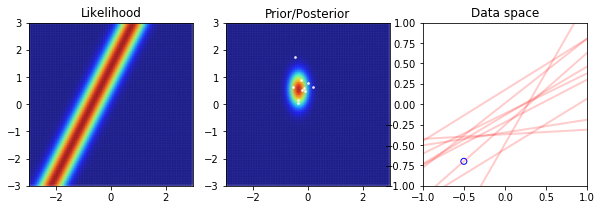

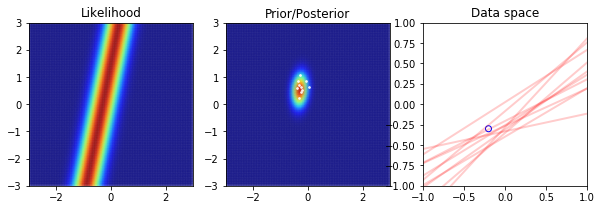

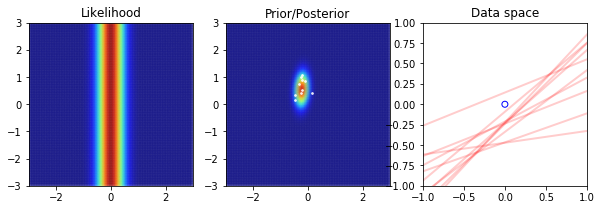

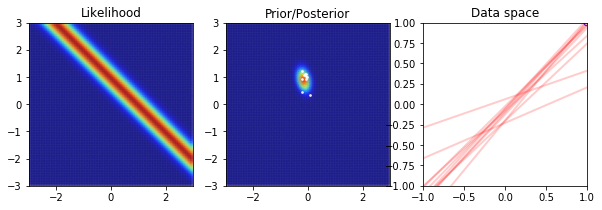

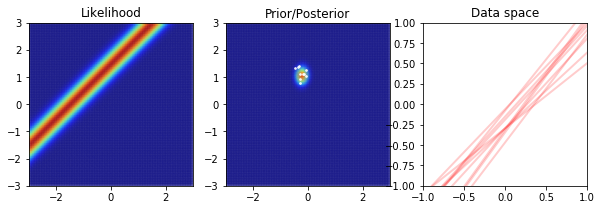

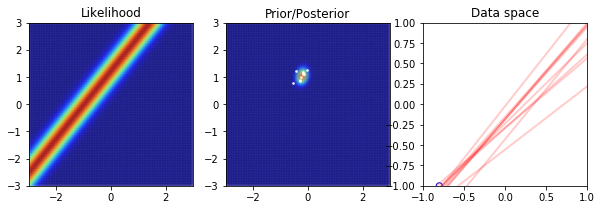

In [22]:
# Hyper parameters
alpha = 1 # Prior precision
beta = 10 # Data precision

#Prior parameters
mean = np.array([0, 0]) # the mean of the prior
covariance = 1/alpha * np.eye(2) # the covariance matrix of the prior

# Plot the prior
plot(data=None, posterior=Gaussian(mean, covariance), beta=beta)

# Dataset : (x, t) pairs
data_list = [[0.5, 0], [-0.5, -0.7], [-0.2, -0.3], [0, 0], [1, 1], [-1, -1.5], [-0.8, -1.0]]

# Draw the posteriors
for data in data_list:
    mean, covariance = update(data, mean, covariance, beta)
    plot(data=data, posterior=Gaussian(mean, covariance), beta=beta)

#### - $\alpha$값을 바꿔가면서 prior/posterior, data space상의 function $y(x,w)$가 어떻게 바뀌는지 봅시다.
#### - $\beta$ 바꿔가면서 likehood function과 Posterior, data space상의 function $y(x,w)$가 어떻게 바뀌는지 봅시다.
#### - sample_num값을 바꿔보면서 data space상의 function $y(x,w)$가 어떻게 바뀌는지 봅시다.
#### - data_list의 값을 바꿔 보면서 likehood function과 Posterior, data space상의 function $y(x,w)$가 어떻게 바뀌는지 봅시다.